<h1> 버스 운행시간 예측

# 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdriv')
data_path = "/content/gdriv/My Drive/Colab Notebooks/study/data" 

import folium
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Mounted at /content/gdriv


In [2]:
# 한글 표시 코드

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,481 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [3]:
train = pd.read_csv(data_path + '/train.csv')
test = pd.read_csv(data_path + '/test.csv')
submission = pd.read_csv(data_path + '/submission_제출양식.csv')

# 데이터 분석

+ id : 고유 id
+ date : 버스 운행 날짜
+ route_id : 버스 노선 ID
+ vh_id : 버스 id
+ route_nm : 버스 노선 실제 번호 -> route_id 와 비슷한 역할
+ now_latitude : 현재 정류소의 위도
+ now_longitude : 현재 정류소의 경도
+ now_station : 현재 정류소 이름
+ now_arrive_time : 현재 정류장에 도착한 시간
+ distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
+ next_station : 다음 정류소 이름
+ next_latitude : 다음 정류소의 위도
+ next_longitude : 다음 정류소의 경도
+ next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값

In [4]:
train.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [6]:
train.describe()

,id,route_id,vh_id,now_latitude,now_longitude,distance,next_latitude,next_longitude,next_arrive_time
count,210457.000000,2.104570e+05,2.104570e+05,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000
mean,105228.000000,4.052491e+08,7.988694e+06,33.434528,126.603451,490.256100,33.434711,126.603687,85.380824
std,60753.847139,9.132404e+04,6.774077e+03,0.102350,0.123961,520.563932,0.102224,0.123838,85.051170
min,0.000000,4.051360e+08,7.983000e+06,33.244382,126.473300,97.000000,33.244382,126.473300,6.000000
25%,52614.000000,4.051365e+08,7.983093e+06,33.325283,126.523900,291.000000,33.325283,126.524550,44.000000
50%,105228.000000,4.053201e+08,7.983431e+06,33.484667,126.551050,384.000000,33.484860,126.551050,66.000000
75%,157842.000000,4.053201e+08,7.997041e+06,33.500197,126.650322,542.000000,33.500228,126.650322,102.000000
max,210456.000000,4.053281e+08,7.997124e+06,33.556167,126.935188,7461.000000,33.556167,126.935188,2996.000000


(array([1.96182e+05, 8.41900e+03, 4.27400e+03, 9.70000e+01, 8.90000e+01,
        8.08000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.88000e+02]),
 array([  97. ,  833.4, 1569.8, 2306.2, 3042.6, 3779. , 4515.4, 5251.8,
        5988.2, 6724.6, 7461. ]),
 <a list of 10 Patch objects>)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


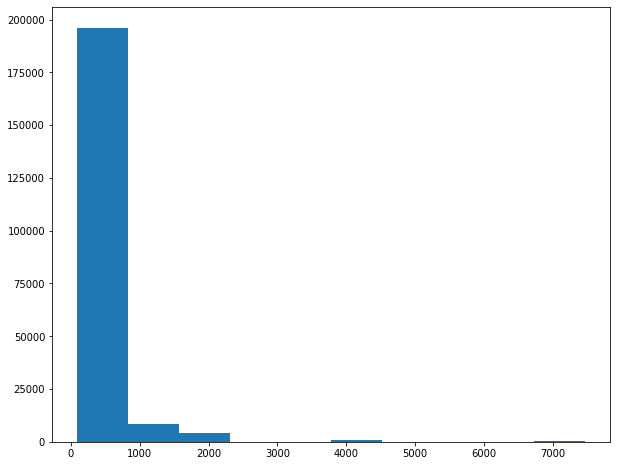

In [7]:
distance = train['distance']
plt.figure(figsize=(10,8))
plt.hist(distance)

(array([21990., 27538., 25535., 25789., 26566., 26262., 23082., 26279.,
         6957.,   459.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


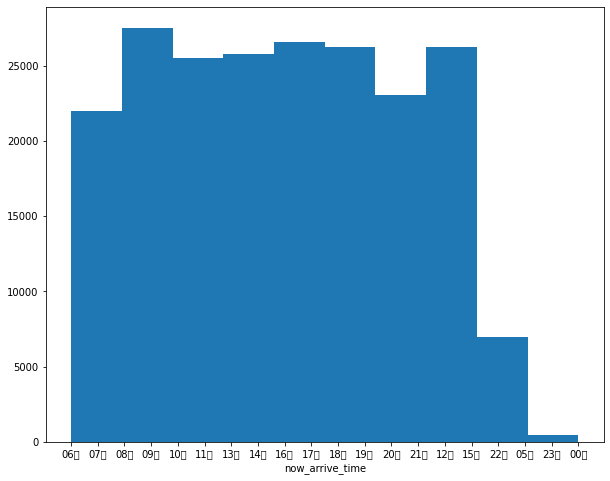

In [8]:
# 현재 정류장 도착한 시간 분포 확인
times = train['now_arrive_time']
plt.figure(figsize=(10,8))
plt.xlabel('now_arrive_time')
plt.hist(times)

- 01~04시 데이터 존재하지 않음 -> 나중에 시간대를 고려할 때 '새벽' 변수는 추가하지 않아도 될 것 같음

(array([2.07537e+05, 2.48600e+03, 2.08000e+02, 7.30000e+01, 3.70000e+01,
        3.40000e+01, 2.00000e+01, 3.00000e+01, 1.60000e+01, 1.60000e+01]),
 array([   6.,  305.,  604.,  903., 1202., 1501., 1800., 2099., 2398.,
        2697., 2996.]),
 <a list of 10 Patch objects>)

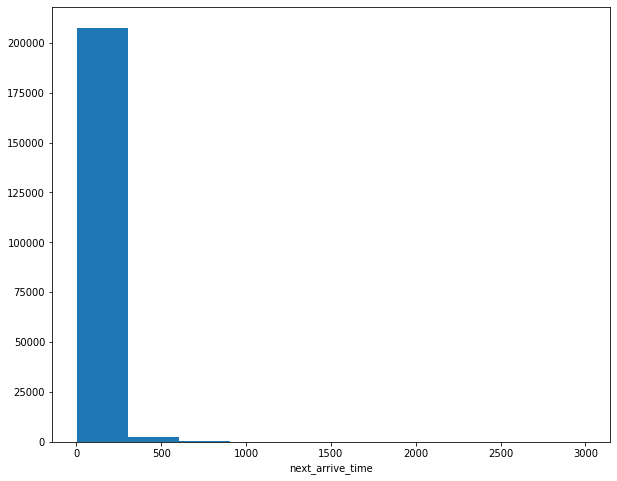

In [9]:
# 예측 시간 분포 확인
target = train['next_arrive_time']
plt.figure(figsize=(10,8))
plt.xlabel('next_arrive_time')
plt.hist(target)

- 다수의 데이터가 0~200 사이에 존재함 -> 1000보다 큰 경우는 삭제..?

In [10]:
train[['route_id', 'next_arrive_time']].groupby('route_id').mean()

,next_arrive_time
route_id,
405136001,92.063688
405136002,108.270852
405136007,94.172947
405136012,111.322633
405136521,114.673939
405136522,101.339188
405320111,68.901710
405320112,67.602392
405320113,68.403649


- 노선마다 평균 소요 시간이 다르다
- 비슷한 거리라도 버스 노선이 도심에 위치하느냐 외곽에 위치하느냐에 따라 소요 시간에 차이가 발생할 것 (도시 중심이면 교통 체증 발생할 것이라 예측)
- 위도와 경도를 이용해서 버스 노선이 어디에 위치하는지 확인

## folium을 사용한 시각화

In [11]:
coord = [33.4134, 126.5190]
map_osm = folium.Map(location = coord)
map_osm

In [12]:
# 버스 노선, 현재 위도, 현재 경도, 현재 정류장 map_data 변수에 저장
map_data = train[['route_id', 'now_latitude', 'now_longitude', 'now_station']]

# 가장 평균 소요 시간이 길었던 노선의 정류장 중복 제거해서 bus route 저장
map_bus_route = map_data[map_data['route_id'] == 405328101].drop_duplicates('now_station')

# 초기 객체 생성 (제주도 위도와 경도 사용)
map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)

print(map_bus_route)

        route_id  now_latitude  now_longitude       now_station
12678  405328101     33.499683     126.521267           남서광마을입구
12679  405328101     33.499789     126.523759             남서광마을
12680  405328101     33.500017     126.525833       탐라장애인 종합복지관
12681  405328101     33.499560     126.529771        제주시청(아라방면)
12682  405328101     33.496007     126.532287        고산동산(아라방면)
12683  405328101     33.493109     126.535091      제주지방법원(아라방면)
12684  405328101     33.489414     126.538642  제주중앙여자고등학교(아라방면)
12685  405328101     33.484860     126.542928   제주여자중고등학교(아라방면)
12686  405328101     33.479705     126.543811         남국원(아라방면)
12687  405328101     33.476533     126.544283            아라초등학교
12688  405328101     33.473655     126.545425           아라주공아파트
12689  405328101     33.471450     126.545400              인다마을
12690  405328101     33.469089     126.547389           제주대학교병원
12691  405328101     33.456718     126.550757           제주대학교입구
12692  405328101     33.452653     126.5

In [13]:
for item in map_bus_route.index:
  lat = map_bus_route.loc[item, 'now_latitude']
  long = map_bus_route.loc[item, 'now_longitude']

  folium.Marker([lat, long], popup = map_bus_route.loc[item, 'now_station'],
                icon = folium.Icon(color = 'blue', icon = 'info_sign')).add_to(map_osm)

map_osm.save('index.html')
map_osm

In [14]:
map_data = train[['route_id', 'now_latitude', 'now_longitude', 'now_station']]
map_bus_route = map_data[map_data['route_id'] == 405320122].drop_duplicates('now_station')

map_osm2 = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)

print(map_bus_route)

        route_id  now_latitude  now_longitude now_station
11173  405320122     33.449467     126.915050     고성리제주은행
11174  405320122     33.462818     126.910286     오조리상동입구
11175  405320122     33.465700     126.908417    성산고입구삼거리
11176  405320122     33.468850     126.905883    성산국민체육센터
11177  405320122     33.474300     126.898450      시흥리사무소
...          ...           ...            ...         ...
58045  405320122     33.518117     126.879019      하도초등학교
58244  405320122     33.303232     126.770509         수농원
58257  405320122     33.391244     126.889330        화성농장
58397  405320122     33.305733     126.773678       신흥1번지
87072  405320122     33.307132     126.786660    토산관광지구입구

[187 rows x 4 columns]


In [15]:
for item in map_bus_route.index:
  lat = map_bus_route.loc[item, 'now_latitude']
  long = map_bus_route.loc[item, 'now_longitude']

  folium.Marker([lat, long], popup = map_bus_route.loc[item, 'now_station'],
                icon = folium.Icon(color = 'blue', icon = 'info_sign')).add_to(map_osm2)

map_osm2.save('index2.html')
map_osm2

- 위도, 경도 변수를 모두 사용하면 모델에 복잡성만 높이는 게 아닐까?
=> 출발 위도,경도랑 도착 위도,경도와의 직선거리를 구해서 변수 추가하는 방법도 존재

<hr>

- route_nm(버스 노선 실제 번호)은 route_id와 역할 비슷
- 위도, 경도 변수 사용할지는 의논
- object형 변수 인코딩
- 시간 관련 변수 오전/오후/저녁으로 나누기
- 날짜 변수 평일/주말로 나누기